In [1]:
import pandas as pd
import numpy as np
import math
import sympy as sy
import json
import scipy
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid
import warnings
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def get_battery(battery_type):

    filename = battery_type+'_cell_data.json'
    f = open(filename)
    data = json.load(f)
    a = data['a']
    b = data['b']
    c = data['c']
    d = data['d']
    n = data['n']
    m = data['m']

    return a,b,c,d,n,m

In [261]:
def calc_Vt_I(sInit, q_pack, P, time, battery_type, n_cells_parallel, n_cells_series):
    #Vterm calculation
    cell_data = pd.DataFrame()
    q_cell = 3600*q_pack/n_cells_parallel#In A-s
    #P_cell = P/(n_cells_parallel*n_cells_series)
    #cell_data['time'] = time
    #cell_data['power'] = P
    
    #DC_data['vterm']=np.zeros(len(DC_data))
    Vterm = np.zeros(len(P))
    I = np.zeros(len(P))
    dt = np.diff(time)
    a,b,c,d,n,m=get_battery(battery_type)

    R=0.0001
    
    for num in range(len(P)):
        if num == 0:
            s = sInit            
            v_ocv=a+b*(-math.log(s))**m+c*s+d*math.exp(n*(s-1))
            Vterm[num] = v_ocv
            I[num] = P[num]/Vterm[num]
            I[num] = (-1)*I[num]
        else:
            del_s=I[num-1]*dt[num-1]/q_cell
            s=s+del_s
            #print(s)
            s = min(s, 1)
            if (s < 0):
                message = "Battery has completely discharged during the drive cycle.\n\t Check if battery pack design is appropriate and initial SoC of the battery pack is correct."
                #logger.warning(message)
                #warnings.warn(message)
                #raise BatteryFullyDischargedError(message)
                s = 1
            v_ocv=a+b*(-math.log(s))**m+c*s+d*math.exp(n*(s-1))
            #print(num, s, v_ocv, P[num], I[num-1])
            Vterm[num] = v_ocv - I[num-1]*R
            I[num] = P[num]/Vterm[num]
            I[num] = (-1)*I[num]
            
    cell_data['vt_cell'] = Vterm
    cell_data['I_cell'] = I
    cell_data['vt_pack'] = Vterm*n_cells_series
    cell_data['I_pack'] = I*n_cells_parallel
    
    return cell_data,s


In [262]:
def velocity_to_current(input_data):
    """
    Converts velocity vs time drive cycle into current vs time

    Parameters
    ----------
    input_data : dictionary
        Dictionary of input parameters in the following format.
        {'drive_cycle_type': 'user_defined',#user_defined,database
         'drive_cycle_file': "US06.csv",
         'drive_cycle_key': "US06", #MIDC, WLTC-Class1, WLTC-Class2, WLTC-Class3, US06, FTP-75
         'terrain': 'flat',#flat, uniform, uneven
         'slope': 5,#slope in degrees for uniform_climb
         'terrain_file': "terrain_info.csv",
         'm_vehicle': 1000,#Mass of the vehicle in kg
         'Afront': 2,#Flontal area of the vehicle m^2
         'Cr': 0.02,#Rolling friction coefficient
         'Cd': 0.02,#Drag coefficient
         'has_regenerative_braking': False, #True, False, if vehicle has regenerative braking system
         'regeneration_factor': 0.4, #Fraction of braking power going into battery
         'eta_DC_AC': 0.9, #AC/DC conversion efficiency
         'eta_motor': 0.9, #Motor mechanical efficiency
         's_init': 0.5, #Initial SoC of the cells
         'pos_ele': LFP, #LFP, LMO, LMNCO, LMNCO_LMO, LTO
         'internal_resistance': 0.0001,#Internal resistance of the battery
         'q_pack': 300, # Capacity of the pack in Ah
         'n_cells_parallel': 10, #Number of cells in parallel in pack
         'n_cells_series':10, #Number of cells in series in pack
         'cycle_id': 'US06', #Drive cycle ID
         }

    Raises
    ------
    Exception
        Invlaid input path.

    Returns
    -------
    Converted drive cycle files and error messages as an output 

    """
    #logger.info("\n=============================\n Conversion started.\n=============================")
    
    #filepath,frontal_area,drag_coeff,vehicle_mass,rolling_res,
    #terrain_amp,terrain_period,ac_dc_conv_eff,motor_mech_eff,v_term=None,slope=None,terrain='flat'):
    drive_cycle_type = input_data['drive_cycle_type']
    filepath = input_data["drive_cycle_file"]
    terrain = input_data['terrain'] or 'flat'
    #logger.info(f"terrain: {terrain}")
    slope = input_data['slope'] or 0
    slope = slope * np.pi/180
    if terrain == 'uneven':
        terrain_file = input_data['terrain_file'] or None
        terrain_df = pd.read_csv(terrain_file)
    
    vehicle_mass = input_data['m_vehicle']
    frontal_area = input_data['Afront']
    rolling_res = input_data['Cr']
    drag_coeff = input_data['Cd']
    has_regenerative_braking = input_data['has_regenerative_braking']
    if (has_regenerative_braking):
        power_factor = input_data['regeneration_factor']
        #logger.info(f"Regerativie braking:  {has_regenerative_braking}, Power factor: {power_factor}")
    else:
        power_factor = 0
        #logger.info(f"Regerativie braking:  {has_regenerative_braking}")
    dc_ac_conv_eff = input_data['eta_DC_AC']
    motor_mech_eff = input_data['eta_motor']
    sInit = input_data['s_init']
    #logger.info(f"Initial SoC: {sInit}")
    battery_type = input_data['pos_ele']
    #logger.info(f"Positive Electrode: {battery_type}")
    q_pack = input_data['q_pack']
    #logger.info(f"Pack capacity: {q_pack}")
    n_cells_parallel = input_data['n_cells_parallel']
    #logger.info(f"n_parallel: {n_cells_parallel}")
    n_cells_series = input_data['n_cells_series']
    #logger.info(f"n_series: {n_cells_series}")
    n_cells = n_cells_parallel*n_cells_series

    

    #log_file=open("filename.log", "a")

    rho=1.225 #kg/m^3
    g=9.8 #m/s^2

    if '.txt' in filepath:
        drive_cycle_data=txt_to_csv(filepath)
        op_file=filepath.replace('.txt','_current_vs_time.csv')
         #print(op_file)
    elif '.csv' in filepath:
        drive_cycle_data=pd.read_csv(filepath)
        #drive_cycle_data=drive_cycle_data.drop(drive_cycle_data.columns[drive_cycle_data.columns.str.contains('Unnamed')==True].to_list(),axis=1)
        op_file=filepath.replace('.csv','_current_vs_time.csv')
    elif '.xlsx' in filepath:
        drive_cycle_data=pd.read_excel(filepath)
        #drive_cycle_data=drive_cycle_data.drop(drive_cycle_data.columns[drive_cycle_data.columns.str.contains('Unnamed')==True].to_list(),axis=1)
        op_file=filepath.replace('.xlsx','_current_vs_time.csv')

    #find time and current columns from data
    time_col_name=drive_cycle_data.columns[np.where(drive_cycle_data.columns.str.lower().str.contains('time')==True)[0].tolist()[0]]

    velocity_col_name=drive_cycle_data.columns[np.where(drive_cycle_data.columns.str.lower().str.contains('velocity|speed')==True)[0].tolist()[0]]
  
    DC_data= drive_cycle_data.apply(pd.to_numeric)
    DC_data = DC_data.astype({time_col_name:'float64'})
    

    #units conversion to m/s
    if 'kmph' in velocity_col_name:
        DC_data[velocity_col_name]=DC_data[velocity_col_name]*5/18
        new_velocity_col_name=velocity_col_name.replace('kmph','mps')
        DC_data.rename({velocity_col_name: new_velocity_col_name}, axis=1, inplace=True)
        velocity_col_name=new_velocity_col_name
    elif 'km/h' in velocity_col_name:
        DC_data[velocity_col_name]=DC_data[velocity_col_name]*5/18
        new_velocity_col_name=velocity_col_name.replace('km/h','mps')
        DC_data.rename({velocity_col_name: new_velocity_col_name}, axis=1, inplace=True)
        velocity_col_name=new_velocity_col_name
        # new_velocity_col_name=velocity_col_name.replace('kmph','mps')
    elif 'mph' in velocity_col_name:
        DC_data[velocity_col_name]=DC_data[velocity_col_name]*0.44704
        new_velocity_col_name=velocity_col_name.replace('mph','mps')
        DC_data.rename({velocity_col_name: new_velocity_col_name}, axis=1, inplace=True)
        velocity_col_name=new_velocity_col_name
 
        #raise KeyError(message)
        #print(DC_data.columns)
        # new_velocity_col_name=velocity_col_name.replace('mph','mps')
    # else:
    #     new_velocity_col_name=velocity_col_name
    #     data1[new_velocity_col_name]=data1[velocity_col_name]

    # try:
    #print(DC_data.columns)
    DC_diff=DC_data.diff()
    DC_diff=DC_diff.fillna(0)
    
    try:
        cnt=np.where(DC_data.columns.str.lower().str.contains('accelaration')==True)[0].tolist()
    except (IndexError):
        status = False
        message = "Index out of bounds error for acceleration data in drive cycle. \n\t"
        logger.error(message)
        raise IndexError(message)
    if len(cnt)>0:
        accelaration_col_name=DC_data.columns[np.where(DC_data.columns.str.lower()
        .str.contains('accelaration')==True)[0].tolist()[0]]
    else: 
        accelaration_col_name = 'accelaration'
        DC_data[accelaration_col_name]=DC_diff[velocity_col_name].div(DC_diff[time_col_name]).replace(np.inf, 0)#DC_diff[velocity_col_name].values/(DC_diff[time_col_name].values+1e-10)
        DC_data[accelaration_col_name]=DC_data[accelaration_col_name].fillna(0)
        # dv_dt=data1[accelaration_col_name]
    # except:
    #     accelaration_col_name = 'accelaration'
    #     data1[accelaration_col_name]=data2[velocity_col_name]/data2[time_col_name]
        # dv_dt=data1[accelaration_col_name]
    
    # #drop unnamed columns
    # data=data.drop(data.columns[data.columns.str.contains('Unnamed')==True].to_list(),axis=1)

    #Calculations:

    # data[accelaration_col_name]

    if terrain == 'flat':
        DC_data['tan_alpha']=pd.DataFrame([0]*len(DC_data))
        DC_data['alpha']=pd.DataFrame([math.atan(i) for i in DC_data['tan_alpha'].values],columns=['alpha'])
    elif terrain == 'uniform':
        DC_data['tan_alpha'] = pd.DataFrame([float(slope)]*len(DC_data))
        DC_data['alpha']=pd.DataFrame([math.atan(i) for i in DC_data['tan_alpha'].values],columns=['alpha'])
    elif terrain == 'uneven':
        # x=[sy.integrate(data[velocity_col_name].iloc[i], (data[time_col_name].iloc[i], 0, data[time_col_name].iloc[i])) for i in range(len(data))]
        #x= cumulative_trapezoid(data1[velocity_col_name],data1[time_col_name],initial=0)
        #h=[terrain_amp*math.sin(val/terrain_period) for val in x]
        #data1['x']=pd.DataFrame(x,columns=['x'])
        #data1['h']=pd.DataFrame(h,columns=['h'])
        
        #PS: Check data column names.
        #terrain_elevation = terrain_df['h']
        #terrain_coord = terrain_df['x']
        terrain_file = input_data['terrain_file']
        terrain_df = pd.read_csv(terrain_file)
        height_col_name=terrain_df.columns[np.where(terrain_df.columns.str.lower().str.contains('elevation|height|altitude')==True)[0].tolist()[0]]
        distance_col_name=terrain_df.columns[np.where(terrain_df.columns.str.lower().str.contains('x|distance')==True)[0].tolist()[0]]

        
        x= cumtrapz(DC_data[velocity_col_name],DC_data[time_col_name],initial=0)
        h = get_height(terrain_df,height_col_name,distance_col_name,x)
        
        #print(type(x), type(h))
        terrain_data = np.vstack((x, h)).T
        #h=[terrain_amp*math.sin(val/terrain_period) for val in x]
        DC_data[['x', 'h']] = terrain_data
        #DC_data['x']=pd.DataFrame(x,columns=['Distance'])
        #DC_data['h']=pd.DataFrame(h,columns=['h'])
        
        #PS: Check data column names.
        terrain_interpolated = pd.DataFrame(terrain_data, columns=['x','h'])
        #terrain_interpolated[['x','h']] = terrain_data
        #terrain_interpolated['x']=pd.DataFrame(x,columns=['Distance'])
        #terrain_interpolated['h']=pd.DataFrame(h,columns=['h'])
        #terrain_elevation = h
        #terrain_coord = x
        dh_dx=terrain_interpolated.diff()
        DC_data['tan_alpha'] = dh_dx['h'].div(dh_dx['x']).replace(np.inf, 0)
        #DC_data['tan_alpha']=pd.DataFrame(dh_dx['h'].values/dh_dx['x'].values)
        DC_data['tan_alpha']=DC_data['tan_alpha'].fillna(0)
        DC_data['alpha']=pd.DataFrame([math.atan(i) if i >= 0 else 0 for i in DC_data['tan_alpha'].values],columns=['alpha'])
        #PS: based on velocity data pick current x by integrating velocity and use interpolation to get corresponding elevation
        #Throw a warning if x values integarated from velocity exceeds x values obtaine
        
    eff_acc = np.where(DC_data[accelaration_col_name] <0,
                                           DC_data[accelaration_col_name] * power_factor,
                                           DC_data[accelaration_col_name])
    fa=vehicle_mass*eff_acc
    # print(fa)
    fd = DC_data[velocity_col_name].apply(lambda x: x**2)*0.5*rho*frontal_area*drag_coeff
    #fd=[0.5*rho*frontal_area*drag_coeff*item**2 for item in DC_data[velocity_col_name].values]
    fr = DC_data['alpha'].apply(lambda x: math.cos(x))*vehicle_mass*rolling_res*g
    #fr=[vehicle_mass*rolling_res*g*math.cos(alpha_val) for alpha_val in DC_data['alpha'].values]
    fg = DC_data['alpha'].apply(lambda x: math.sin(x))*vehicle_mass*g
    #fg=[vehicle_mass*g*math.sin(alpha_val) for alpha_val in DC_data['alpha'].values]

    fv_res=np.sum([fa.tolist(),fd.tolist(),fr.tolist(),fg.tolist()],axis=0)
    fv_res_df=pd.DataFrame(fv_res,columns=['fv_res'])
    # print(fv_res)

    DC_data['pwheel']=DC_data[velocity_col_name]*fv_res_df['fv_res']
    DC_data['pb']=DC_data['pwheel']/(dc_ac_conv_eff*motor_mech_eff)
    
    P = DC_data['pb']/n_cells
    time = DC_data[time_col_name]
    df,s_final = calc_Vt_I(sInit, q_pack, P, time, battery_type, n_cells_parallel, n_cells_series)
    #print(DC_data)
    #print(df)
    DC_data_mod = pd.concat([DC_data, df], axis=1)
    #print(DC_data_mod)
    #req_cols=['current',time_col_name]
    DC_data_mod.to_csv(op_file,index=False)
    
    time = DC_data_mod[time_col_name]
    V_pack = DC_data_mod['vt_pack']
    I_pack = DC_data_mod['I_pack']
    vel = DC_data_mod[velocity_col_name]
    
    #logger.info("Writing voltage output.")
    #Voltage_file = OUTPUT_PATH + CYCLE_ID + '_voltage.json'
    #if nz == 1 else v_cells[:,0,0,0]*modProp.n_cells_series                  
    Voltage = []
    for j in range(len(time)):#PRASHANT: Check why voltage at the last time step is going to zero
        data = {"time": time[j], "voltage": V_pack[j]}
        Voltage.append(data)
   
    #logger.info("Voltage written successfully.")
    
    #logger.info("Writing current output.")
    #Current_file = OUTPUT_PATH + CYCLE_ID + '_current.json'
    #if nz == 1 else v_cells[:,0,0,0]*modProp.n_cells_series                  
    Current = []
    for j in range(len(time)):#PRASHANT: Check why voltage at the last time step is going to zero
        data = {"time": time[j], "current": I_pack[j]}
        Current.append(data)
    
    #logger.info("Current written successfully.")
    
    #logger.info("Writing velocity output.")
    #Vel_file = OUTPUT_PATH + CYCLE_ID + '_velocity.json'
    #if nz == 1 else v_cells[:,0,0,0]*modProp.n_cells_series                  
    Vel = []
    for j in range(len(time)):#PRASHANT: Check why voltage at the last time step is going to zero
        data = {"time": time[j], "velocity": vel[j]}
        Vel.append(data)
   
    #logger.info("Velocity written successfully.")
    #logger.info("\n============================\nConversion completed successfully.\n============================")
    output = {"drive_cycle_file": op_file}
    return(output),s_final

In [293]:
input_data = {'drive_cycle_type': 'builtin',#user_defined,builtin
 'drive_cycle_file': "US06.csv",#File path of the drive cycle
 'drive_cycle_key': "US06",#Drive cycle file key for builtin drive cycles
 'terrain': 'uniform',#flat, uniform, uneven
 'slope': 5,#slope in degrees for uniform_climb
 'terrain_file': "./Terrain_info.csv",
 'm_vehicle': 1000,#Mass of the vehicle in kg
 'Afront': 2,#Flontal area of the vehicle m^2
 'Cr': 0.02,#Rolling friction coefficient
 'Cd': 0.02,#Drag coefficient
 'has_regenerative_braking': False, #True, False, if vehicle has regenerative braking system
 'regeneration_factor': 0.4, #Fraction of braking power going into battery
 'eta_DC_AC': 0.9, #AC/DC conversion efficiency
 'eta_motor': 0.9, #Motor mechanical efficiency
 's_init': 0.5, #Initial SoC of the cells
 'pos_ele': 'LNMCO', #Battery chemistry
 'internal_resistance': 0.0001, #Internal resistance of the battery
 'q_pack': 60, #Cell capacity
 'n_cells_parallel': 20, #Number of cells in parallel in pack
 'n_cells_series': 100, #Number of cells in series in pack
 'cycle_id': 'US06', #Drive cycle ID
 'battery_type': 'LFP'
 }

In [294]:
def cc_cv(input_data,rest_period,c_rate,no_of_cycles,battery_capacity):
    
    """
     Parameters
    ----------
    input_data : dictionary
        Dictionary of input parameters in the following format.
        {'drive_cycle_file': "US06.csv",
         'terrain': 'flat',#flat, uniform, uneven
         'slope': 5,#slope in degrees for uniform_climb
         'terrain_file': "terrain_info.csv",
         'm_vehicle': 1000,#Mass of the vehicle in kg
         'Afront': 2,#Flontal area of the vehicle m^2
         'Cr': 0.02,#Rolling friction coefficient
         'Cd': 0.02,#Drag coefficient
         'eta_ac_dc': 0.9, #AC/DC conversion efficiency
         'eta_motor': 0.9, #Motor mechanical efficiency
         's_init': 0.5, #Initial SoC of the cells
         'q_cell': 3, #Capaicty in Ah
         'n_cell': 100, #Number of cells in pack
         'battery_type': 'LFP' #Type of battery used
         }
    rest period in sec (Resting Period after charging cycle)
    c_rate : rate at which a battery is discharged relative to its maximum capacity
    no_of_cycles
    battery_capacity: maximum capacity
    """
    q_pack = input_data['q_pack']
    battery_type = input_data['battery_type']
    n_cells_parallel = input_data['n_cells_parallel']
    q_cell = 3600*q_pack/n_cells_parallel
    current = ((c_rate)*(battery_capacity))
    a,b,c,d,n,m = get_battery(battery_type)
    R = 0.1
    
    for r in range(no_of_cycles+1):
        print(r)
        if(r==0):
            output, current_soc = velocity_to_current(input_data)
            df = pd.read_csv(output["drive_cycle_file"])
            time_col_name=df.columns[np.where(df.columns.str.lower().str.contains('time')==True)[0].tolist()[0]]
            current_col_name=df.columns[np.where(df.columns.str.lower().str.contains('i_pack')==True)[0].tolist()[0]]
            voltage_col_name=df.columns[np.where(df.columns.str.lower().str.contains('vt_pack')==True)[0].tolist()[0]]
            time_list =df.filter([time_col_name]).values.reshape(1, -1).ravel().tolist()
            current_list =df.filter([current_col_name]).values.reshape(1, -1).ravel().tolist()
            vol_list =df.filter([voltage_col_name]).values.reshape(1, -1).ravel().tolist()
            
            if(current_soc < 0.8):
                remain_charge_frac = 0.8 - current_soc
                del_t = (remain_charge_frac*q_cell)/(current*100)
                t = time_list[-1]
                i=0
                while(i < 100):
                    v_ocv=a+b*(-math.log(current_soc))**m+c*current_soc+d*math.exp(n*(current_soc-1))
                    del_s = current*del_t/q_cell
                    current_soc = current_soc + del_s
                    vol = v_ocv + current*R
                    current_list.append(current)
                    vol_list.append(vol)
                    time_list.append(t+1)
                    t=t+1
                    i=i+1
                    print(current_soc)
             
            
            voltage = vol_list[-1]
            curr = curr_max = current_list[-1]
            remain_charge_frac = 1 - current_soc
            time_req = 2*(remain_charge_frac/c_rate)*3600
            alpha = math.log(10)/time_req
            t=time_list[-1]
            i=1
            while(current_soc<1 and i<time_req):
                v_ocv=a+b*(-math.log(current_soc))**m+c*current_soc+d*math.exp(n*(current_soc-1))
                curr= curr_max*(math.exp(-1*alpha*(i+100)))
                del_s = curr*0.01/q_cell
                current_soc = current_soc+del_s
                vol = voltage + v_ocv
                vol_list.append(voltage)
                current_list.append(curr)
                time_list.append(t+i+100)
                i=i+100
                print(current_soc)
            
            #lt = time_list[-1]
            #v = vol_list[-1]
            #for t in range(rest_period):
                #time_list.append(t+lt+1)
                #current_list.append(0)
                #vol_list.append(vol)
            
                
                
            input_data['s_init'] = 1 
        else:
            output, current_soc = velocity_to_current(input_data)
            df_new = pd.read_csv(output["drive_cycle_file"])
            current_list = current_list+ df_new.filter([current_col_name]).values.reshape(1, -1).ravel().tolist()
            if(current_soc< 0.8):
                remain_charge_frac = 0.8 - current_soc
                del_t = (remain_charge_frac*q_cell)/(current*100)
                t = time_list[-1]
                i=0
                while(i < 100):
                    v_ocv=a+b*(-math.log(current_soc))**m+c*current_soc+d*math.exp(n*(current_soc-1))
                    del_s = current*del_t/q_cell
                    current_soc = current_soc+ del_s
                    vol = v_ocv + current*R
                    current_list.append(current)
                    vol_list.append(vol)
                    time_list.append(t+1)
                    t=t+1
                    i=i+1
                    print(current_soc)
             
            
            voltage = vol_list[-1]
            curr = curr_max = current
            remain_charge_frac = 1 - current_soc
            time_req = 2*(remain_charge_frac/c_rate)*3600
            alpha = math.log(10)/time_req
            t=time_list[-1]
            i=1
            while(current_soc<1 and i<time_req):
                v_ocv=a+b*(-math.log(current_soc))**m+c*current_soc+d*math.exp(n*(current_soc-1))
                curr= curr_max*(math.exp(-1*alpha*(i+100)))
                del_s = curr*0.01/q_cell
                current_soc = current_soc+del_s
                vol = voltage + v_ocv
                vol_list.append(voltage)
                current_list.append(curr)
                time_list.append(t+i+100)
                i=i+100
                print(current_soc)
            
            #lt = time_list[-1]
            #v = vol_list[-1]
            #for t in range(rest_period):
                #time_list.append(t+lt+1)
                #current_list.append(0)
                #vol_list.append(vol)
            
                
                
            input_data['s_init'] = 1 
            
            
           
    dft=pd.DataFrame(time_list)
    dfc=pd.DataFrame(current_list)
    #ig, ax = plt.subplots()
    plt.plot( dfc)

    #ax.set_xlabel('time')
    #ax.set_ylabel('current', color='C0')
                    
                    
                    
            

0
0.7736122440507072
0.7738787870400939
0.7741453300294807
0.7744118730188675
0.7746784160082543
0.774944958997641
0.7752115019870278
0.7754780449764146
0.7757445879658014
0.7760111309551881
0.7762776739445749
0.7765442169339617
0.7768107599233485
0.7770773029127352
0.777343845902122
0.7776103888915088
0.7778769318808956
0.7781434748702823
0.7784100178596691
0.7786765608490559
0.7789431038384427
0.7792096468278294
0.7794761898172162
0.779742732806603
0.7800092757959898
0.7802758187853766
0.7805423617747633
0.7808089047641501
0.7810754477535369
0.7813419907429237
0.7816085337323104
0.7818750767216972
0.782141619711084
0.7824081627004708
0.7826747056898575
0.7829412486792443
0.7832077916686311
0.7834743346580179
0.7837408776474046
0.7840074206367914
0.7842739636261782
0.784540506615565
0.7848070496049517
0.7850735925943385
0.7853401355837253
0.7856066785731121
0.7858732215624988
0.7861397645518856
0.7864063075412724
0.7866728505306592
0.7869393935200459
0.7872059365094327
0.7874724794988

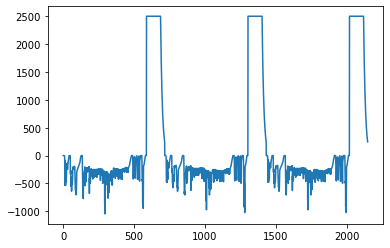

In [295]:
cc_cv(input_data,100,0.5,2,5000)